In [1]:
!pip install -Uqq fastbook

# Bird Classifier (Vision)

In [18]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
import os

In [3]:
urls = search_images_ddg('bird photos', max_images=1)
len(urls),urls[0]

(1,
 'https://www.birdsandblooms.com/wp-content/uploads/2021/02/11_ScottDiedrich_BBfm20.jpg')

In [4]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)

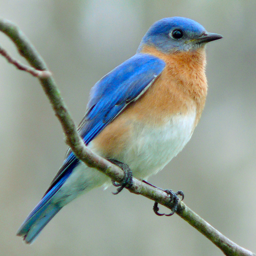

In [5]:
im = Image.open(dest)
im.to_thumb(256,256)

In [6]:
searches = ['forest', 'bird']
path = 'bird_or_not'

if not os.path.exists(path):
    os.makedirs(path)

for o in searches:
    dest = os.path.join(path, o)
    if not os.path.exists(dest):
        os.makedirs(dest)
    results = search_images_ddg(f'{o} photo')
    download_images(dest, urls=results[:200])
    resize_images(dest, max_size=400, dest=dest)

### Step 2: Train model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);

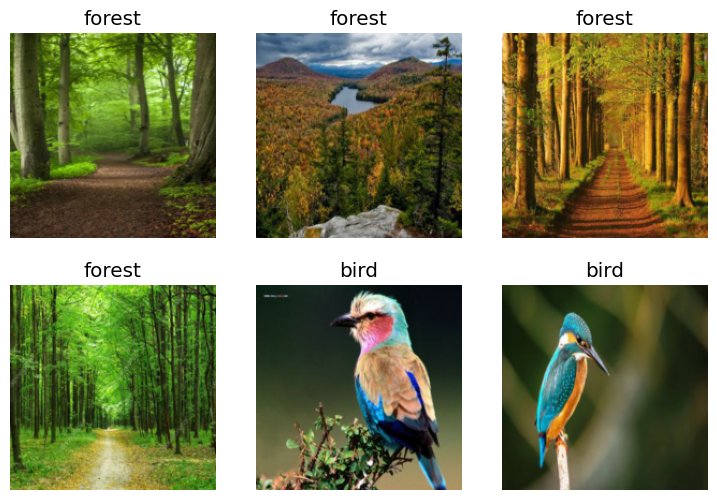

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.482638,0.029398,0.013423,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.026504,0.000191,0.000000,00:01
1,0.012245,0.000276,0.000000,00:01
2,0.007577,0.000308,0.000000,00:01


### Step 3: Use/Build your own model

In [10]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"this is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

this is a: bird.
Probability it's a bird: 1.0000


## Segmentation

In [11]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.989006,2.301842,00:01


epoch,train_loss,valid_loss,time
0,1.928065,1.735144,00:01
1,1.720968,1.345452,00:01
2,1.596379,1.156500,00:01
3,1.439442,0.984347,00:01
4,1.292017,0.844898,00:01
5,1.169364,0.789939,00:01
6,1.066196,0.761540,00:01
7,0.985438,0.741436,00:01


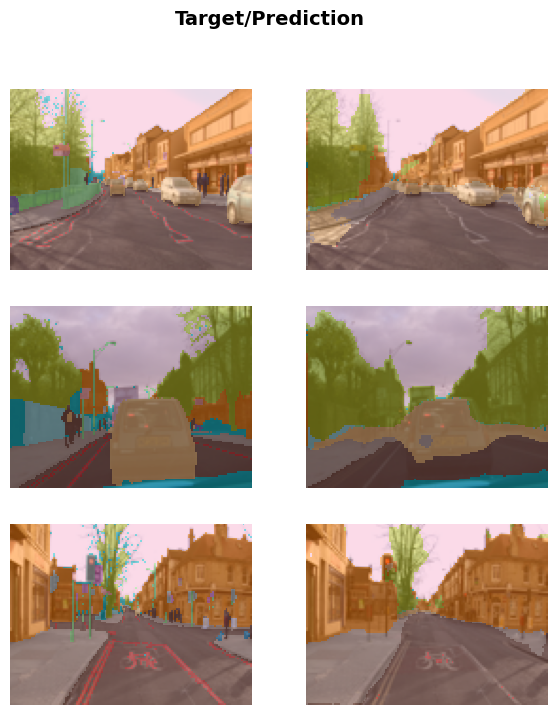

In [12]:
learn.show_results(max_n=3, figsize=(7,8))

# Tabular Analysis

In [16]:
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
                                  cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'education-num_na'],
                                  cont_names = ['age', 'fnlwgt', 'education-num'],
                                  procs = [Categorify, FillMissing, Normalize])
dls.show_batch()

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Some-college,Married-civ-spouse,Sales,Husband,White,False,55.999999,220186.999466,10.0,>=50k
1,Self-emp-not-inc,7th-8th,Married-civ-spouse,Other-service,Husband,White,False,64.000000,167148.999523,4.0,<50k
2,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,False,45.000000,98092.002969,9.0,<50k
3,Private,Bachelors,Never-married,Prof-specialty,Unmarried,Black,False,31.000000,375679.997358,13.0,<50k
4,Private,Some-college,Married-civ-spouse,Sales,Husband,White,False,23.000000,62277.999468,10.0,<50k
5,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,False,42.000000,169994.999243,9.0,<50k
6,Private,5th-6th,Married-civ-spouse,Handlers-cleaners,Husband,White,False,31.000000,138415.998593,3.0,<50k
7,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,49.000000,50474.000199,9.0,<50k
8,Private,11th,Never-married,Sales,Own-child,White,False,17.000000,198123.999646,7.0,<50k
9,Private,Assoc-acdm,Divorced,Craft-repair,Not-in-family,White,False,43.000000,57322.003745,12.0,<50k


### Build model

In [17]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.386443,0.373002,0.830620,00:02
1,0.349378,0.362754,0.835534,00:02


# Collaborative Filtering - Recommendation System

In [20]:
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
dls.show_batch()

,userId,movieId,rating
0,212,1221,5.0
1,130,1704,3.0
2,423,588,1.5
3,78,1270,4.5
4,355,1193,4.5
5,463,47,4.0
6,468,778,4.0
7,353,2571,3.5
8,176,2716,2.5
9,665,34,2.0


In [21]:
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.516277,1.403493,00:00


epoch,train_loss,valid_loss,time
0,1.374189,1.341654,00:00
1,1.276572,1.151194,00:00
2,1.012470,0.847883,00:00
3,0.802548,0.713950,00:00
4,0.701216,0.684469,00:00
5,0.652846,0.675989,00:00
6,0.636176,0.671770,00:00
7,0.621005,0.669571,00:00
8,0.607962,0.668802,00:00
9,0.611623,0.668743,00:00


In [22]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,62.0,74.0,3.0,3.677210
1,10.0,98.0,5.0,3.984293
2,39.0,91.0,4.0,3.791996
3,64.0,98.0,4.5,4.068123
4,96.0,89.0,3.5,3.309551
5,47.0,63.0,5.0,4.730493
6,41.0,24.0,4.0,3.514192
7,40.0,37.0,4.0,3.477838
8,62.0,8.0,4.0,3.752988
